In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
# The following is only for working with RDDs
# from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [132]:
traindata = pd.read_csv('data/new_subset_data/final_train_data.csv')
testdata = pd.read_csv('data/new_subset_data/final_test_data.csv')

sp_train = spark.createDataFrame(traindata)
sp_test = spark.createDataFrame(testdata)

In [133]:
#Change column names to something Spark has hardcoded into their GridSearch feature for dataframes
oldColumns = sp_train.schema.names
newColumns = ["user", "item", "rating"]

sp_train = reduce(lambda sp_train, idx: sp_train.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), sp_train)
sp_train.printSchema()

#Change column names to something Spark has hardcoded into their GridSearch feature for dataframes
oldColumns = sp_test.schema.names
newColumns = ["user", "item", "rating"]

sp_test = reduce(lambda sp_test, idx: sp_test.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), sp_test)
sp_test.printSchema()

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)



# Load entire dataset for use in crossval gridsearch

In [100]:
entiredata = pd.read_csv('data/new_subset_data/ratings_data.csv', sep='\t')

sp_entire = spark.createDataFrame(entiredata)

In [101]:
#Change column names to something Spark has hardcoded into their GridSearch feature for dataframes
oldColumns = sp_entire.schema.names
newColumns = ["user", "item", "rating"]

sp_entire = reduce(lambda sp_entire, idx: sp_entire.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), sp_entire)
sp_entire.printSchema()
sp_entire.show()

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)

+----+----+------+
|user|item|rating|
+----+----+------+
|   4|   2|   4.0|
|  23|   3|   4.0|
|  28|   5|   4.0|
|  31|   6|   4.0|
|  67|  10|   6.0|
|  69|  11|   4.0|
|  78|  19|   4.0|
|  86|  23|   4.0|
|  89|  27|   4.0|
| 111|  29|   4.0|
| 136|  31|   4.0|
| 142|  34|   4.0|
| 145|  35|   4.0|
| 159|  37|   4.0|
| 161|  39|   4.0|
| 166|  40|   4.0|
| 178|  42|   4.0|
| 208|  49|   4.0|
| 216|  52|   4.0|
| 272|  55|   4.0|
+----+----+------+
only showing top 20 rows



In [102]:
# define models using different ranks
model0 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=1,
    maxIter=15
    ) 

model1 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=5,
    maxIter=15
    ) 

model2 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=7,
    maxIter=15
    )

model3 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10,
    maxIter=15
    )

model4 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=15,
    maxIter=15
    )

model5 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=20,
    maxIter=15
    )

model6 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15
    )

model7 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=30,
    maxIter=15
    )

model8 = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=40,
    maxIter=15
    )

In [103]:
# Fit models
recommender0 = model0.fit(sp_train)
recommender1 = model1.fit(sp_train)
recommender2 = model2.fit(sp_train)
recommender3 = model3.fit(sp_train)
recommender4 = model4.fit(sp_train)
recommender5 = model5.fit(sp_train)
recommender6 = model6.fit(sp_train)
recommender7 = model7.fit(sp_train)
recommender8 = model8.fit(sp_train)

models = [recommender0, recommender1, recommender2, recommender3, recommender4, 
          recommender5, recommender6, recommender7, recommender8]

In [104]:
def evaluate_models(trained_models, testdf, metric='rmse'):
    '''
    INPUT: list of trained models, and spark dataframe of training data
    OUTPUT: list of rmses, and list of ranks associated with models
    
    trained_models = [recommender1, recommender2]
    testdf = spark.createDataFrame(test_pandas_df)
    
    rmses, ranks =  evaluate_models(trained_models, testdf)
    '''
    ranks = []
    rmses = []
    for model in trained_models:
        predictions = model.transform(testdf)
        pred_df = predictions.toPandas()
        rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))
        
        predictions = rawPredictions\
        .withColumn("rating", rawPredictions.rating.cast("double"))\
        .withColumn("prediction", rawPredictions.prediction.cast("double"))
       
        evaluator =\
        RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        
        ranks.append(model.rank)
        rmses.append(rmse)
    return rmses, ranks
    

In [105]:
rmses, ranks = evaluate_models(models, sp_test, metric='rmse')

In [106]:
rmsestrain, rankstrain = evaluate_models(models, sp_train, metric='rmse')

# Use 25-30 latent features (rank)

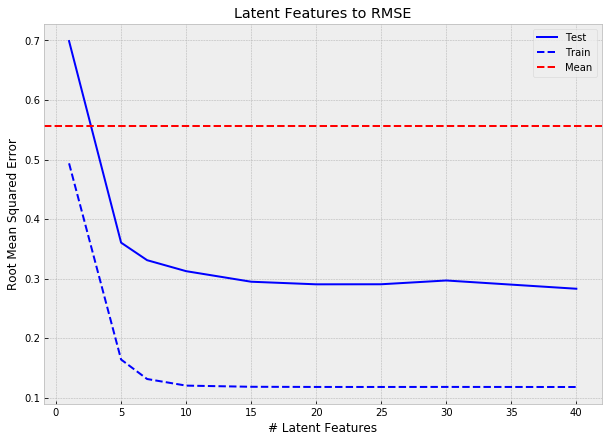

In [118]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(ranks, rmses, label='Test', c='blue')
ax.plot(rankstrain, rmsestrain, label='Train', c='blue', ls='dashed')
ax.axhline(mean_rmse, label='Mean', ls='dashed', c='red')

ax.set_title("Latent Features to RMSE")
ax.set_ylabel("Root Mean Squared Error")
ax.set_xlabel("# Latent Features")
ax.legend()
fig.savefig('/home/ubuntu/PROJECT/github-collaborator/matplots/RMSE.png');

### playing with imputing random 'predictions' instead of actual predictions

In [119]:
np.random.choice([2.0, 4.0, 6.0])

6.0

In [120]:
fakedf = pd.DataFrame({'actual': [2.0, 2.0, 6.0, 4.0]})
fakedf['prediciton'] = pd.Series([np.random.choice([2.0, 4.0, 6.0]) for _ in range(fakedf.shape[0])])
fakedf

,actual,prediciton
0,2.0,6.0
1,2.0,2.0
2,6.0,2.0
3,4.0,2.0


In [121]:
fakemean = np.mean(fakedf.actual)
fakemean

3.5

In [122]:
fakedf['prediciton'] = fakemean
fakedf

,actual,prediciton
0,2.0,3.5
1,2.0,3.5
2,6.0,3.5
3,4.0,3.5


# Final model performance

In [119]:
sp_test.printSchema()

root
 |-- user: long (nullable = true)
 |-- item: long (nullable = true)
 |-- rating: double (nullable = true)



In [120]:
final_als = ALS(
    itemCol='item',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=25,
    maxIter=15
    ) 
final_model = final_als.fit(sp_train)

fin_rmses, fin_ranks = evaluate_models([final_model], sp_test, metric='rmse')

In [121]:
"Final model has RMSE of : {:.4f}".format(fin_rmses[0])

'Final model has RMSE of : 0.2904'

# Versus predicting random rank for all (2, 4, or 6)

In [111]:
import numpy as np

# Using random choice of 2, 4, or 6
predictions_random = alsModel.transform(sp_test)

pred_df = predictions_random.toPandas()
pred_df = pred_df.dropna(axis=0)
pred_df['prediction'] = pd.Series([np.random.choice([2.0, 4.0, 6.0]) for _ in range(pred_df.shape[0])])

rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))

predictions = rawPredictions\
.withColumn("rating", rawPredictions.rating.cast("double"))\
.withColumn("prediction", rawPredictions.prediction.cast("double"))

evaluator =\
RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rand_rmse = evaluator.evaluate(predictions)

print "Model imputed with random rank values for predictions has RMSE of : {:.4f}".format(rand_rmse)

Model imputed with random rank values for predictions has RMSE of : 2.5818


In [145]:
import numpy as np

# Using mean rank
predictions_random = alsModel.transform(sp_test)

pred_df = predictions_random.toPandas()
mean_rank = np.mean(pred_df.rating)
pred_df = pred_df.dropna(axis=0)
pred_df['prediction'] = mean_rank

rawPredictions = spark.createDataFrame(pred_df.dropna(axis=0))

predictions = rawPredictions\
.withColumn("rating", rawPredictions.rating.cast("double"))\
.withColumn("prediction", rawPredictions.prediction.cast("double"))

evaluator =\
RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mean_rmse = evaluator.evaluate(predictions)

print "Model imputed with random rank values for predictions has RMSE of : {:.4f}".format(mean_rmse)

Model imputed with random rank values for predictions has RMSE of : 0.5560


# Save Final Model

In [123]:
final_model.save("/home/ubuntu/PROJECT/github-collaborator/data/models/finalModel")

# GridSearch

In [134]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [139]:
als = ALS(nonnegative=True)

paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter, [15, 30]) \
    .addGrid(als.regParam, [1, 0.1, 0.01, 5]) \
    .addGrid(als.rank, [10,15,20,25,30,35,40]) \
    .build()
    
crossval = CrossValidator(estimator=als,
                      estimatorParamMaps=paramGrid,
                      evaluator=RegressionEvaluator(
                          metricName="rmse", 
                          labelCol="rating"),
                      numFolds=7)

# Run cross-validation, and choose the best set of parameters.
alsModel = crossval.fit(sp_train)
alsModel.bestModel.save('/home/ubuntu/PROJECT/github-collaborator/data/models/CVmodel')

In [143]:
alsModel = ALSModel.load('/home/ubuntu/PROJECT/github-collaborator/data/models/CVmodel')
alsModel.

In [128]:
cvrmses, cvranks = evaluate_models([alsModel.bestModel], sp_test, metric='rmse')

In [140]:
cvrmses

[0.9676345450302812]

In [141]:
cvranks

[10]

## Recommend

In [146]:
Model = ALSModel.load("/home/ubuntu/PROJECT/github-collaborator/data/models/finalModel")
CVModel = ALSModel.load('/home/ubuntu/PROJECT/github-collaborator/data/models/CVmodel/')

In [147]:
repos = pd.read_pickle('data/pickled/new_subset_repos.pkl')
users = pd.read_pickle('data/pickled/new_subset_users.pkl')

In [150]:
int(users['id'].loc[users['login'] == 'caitriggs'])

3384558

In [82]:
def recommend_repos(model, users_df, repos_df, username):
    user = int(users_df['id'].loc[users_df['login'] == username])
    prediction_df = pd.DataFrame(repos_df['id'])
    prediction_df['user'] = user
    prediction_df = prediction_df.rename(columns={'id':'item'})
    
    pred_df = spark.createDataFrame(prediction_df)
    predictions_user = model.transform(pred_df)
    return predictions_user.toPandas().sort_values('prediction', ascending=False).head(10)
    

In [151]:
cait_reco = recommend_repos(Model, users, repos, 'caitriggs')
cait_reco

Index([u'item', u'user'], dtype='object')


,item,user,prediction
168844,32144805,3384558,6.549193
943443,13745548,3384558,6.495636
585358,10908073,3384558,6.495636
717768,1098428,3384558,6.495636
741020,21509204,3384558,6.441789
96674,2559614,3384558,6.358458
66780,26336982,3384558,6.358389
221087,12983788,3384558,6.342174
577086,42964577,3384558,6.342174
249199,28085873,3384558,6.313771


In [152]:
cait_reco_cv = recommend_repos(CVModel, users, repos, 'caitriggs')
cait_reco_cv

Index([u'item', u'user'], dtype='object')


,item,user,prediction
166642,5376946,3384558,3.979448
1055674,15409390,3384558,3.979329
939597,34001531,3384558,3.979177
404725,27313720,3384558,3.979140
643148,2946617,3384558,3.979140
414833,19478412,3384558,3.979106
698709,25260835,3384558,3.979105
671879,27435507,3384558,3.979023
247773,9729989,3384558,3.979020
328471,11428670,3384558,3.978911


In [157]:
#Top recommendations from Model
repos[repos.id == 2559614]

,id,url,owner_id,name,language,created_at,forked_from
290462,10908073,https://api.github.com/repos/pkt/apt-transport...,343773,apt-transport-sftp,C++,2012-03-13 15:28:49,0


In [159]:
# Top recommendations from CVModel
repos[repos.id == 25260835]

,id,url,owner_id,name,language,created_at,forked_from
512671,25260835,https://api.github.com/repos/robeastham/RealSe...,7575,RealSense_ROS,C++,2015-09-10 10:38:42,25046894
